Distributed network for the Hats problem

In [1]:
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Conv1D, MaxPool1D
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.layers import Flatten, Reshape, Dropout

Using TensorFlow backend.


In [2]:
def test_accuracy(Q_net):
    number_of_agents = int(np.sqrt(int(model.layers[0].input.shape[1])))#len(Q_nets)
    Q = Q_net
    reward = 0
    for ep in range(100):
        hats = [np.random.randint(number_of_agents) for i in range(number_of_agents)]
#         hats = hats_set[np.random.randint(len(hats_set))]
        
        states = [hats[:i] + hats[i+1:] for i in range(number_of_agents)]
        #The Q-Network
        #Take actions in for the agents
        actions = []
        batch = []
        for i in range(number_of_agents):
            state = states[i]
            q_input = [bite for color in state \
                       for bite in (color * [0] + [1] + (number_of_agents - color - 1) * [0])]
            #apend agent's index
            q_input += i * [0] + [1] + (number_of_agents - i - 1) * [0]
            batch.append(np.reshape(q_input, (-1, number_of_agents * number_of_agents)))
            
            
        predictions = model.predict( np.reshape(batch,\
                                        (number_of_agents, number_of_agents * number_of_agents, 1))\
                            , batch_size=number_of_agents)

        actions = [p.argmax() for p in predictions] 
        preds = np.choose(actions, predictions.T)
        actions = list(zip(actions, predictions))

        validate = sum(actions[x][0] == hats[x] for x in range(number_of_agents))
        r = 0
        r += 1 if validate >= 1 else 0
        reward += r
    return reward / 100.

In [3]:
number_of_agents = 2

model = Sequential()
model.add(Conv1D(30, number_of_agents, strides=number_of_agents,\
                 padding='same', input_shape=(number_of_agents * number_of_agents, 1)))
# model.add(Flatten(input_shape=(number_of_agents * number_of_agents, 1)))
model.add(Flatten())
model.add(Reshape((1, -1)))
model.add(LSTM(20))
# model.add(Reshape((1, 8)))
# model.add(LSTM(8))
# model.add(Dense((64, 64), activation='relu'))
# model.add(Dense(30, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(40, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(9, activation='relu'))
#model.add(Flatten())
model.add(Dense(number_of_agents, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# models.append(model)

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 2, 30)             90        
_________________________________________________________________
flatten_4 (Flatten)          (None, 60)                0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 1, 60)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                6480      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                672       
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 297       
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 20        
Total para

In [4]:
print("There are a total of {0:d} trainable parameters."\
      .format(model.count_params()))
print("The probability of random succes is {0:.2f}."\
      .format(1 - (((number_of_agents - 1) / number_of_agents) ** number_of_agents)))

There are a total of 7559 trainable parameters.
The probability of random succes is 0.75.


In [ ]:
#Curriculum Learning approach


# hats_set = [[np.random.randint(number_of_agents) for i in range(number_of_agents)] for case in range(50)]
# len(set([tuple(hats) for hats in hats_set]))
# hats_set = list(set([tuple(hats) for hats in hats_set]))

In [84]:
# Set learning parameters
e = 0.2
num_episodes = 1 * (10 ** 4)
#create lists to contain total rewards and steps per episode
rList = []#test_accuracy(model)]
rAll = 0
repetitions = 4

for ep in range(num_episodes):
    #initialize hats
    
    hats_seq   = []
    result_seq = []
    r_sum      = 0
    for i in range(repetitions):
        hats = [np.random.randint(number_of_agents) for i in range(number_of_agents)]
        while(sum(hats) % number_of_agents != 0):
            hats = [np.random.randint(number_of_agents) for i in range(number_of_agents)]

        #trasform the seen hats into inputs for the network
        states = [hats[:i] + hats[i+1:] for i in range(number_of_agents)]

        #The Q-Network
        #Take actions in for the agents
        actions = []
        mini_batch = []
        for i in range(number_of_agents):
            state = states[i]

            #one hot encode what the agent sees
            q_input = [bite for color in state \
                       for bite in (color * [0] + [1] + (number_of_agents - color - 1) * [0])]
            #apend agent's index
            q_input += i * [0] + [1] + (number_of_agents - i - 1) * [0]
            mini_batch.append(np.reshape(q_input, (-1, number_of_agents * number_of_agents)))
            
        hats_seq.append(mini_batch)
        predictions = model.predict( np.reshape(mini_batch,\
                                                (number_of_agents, number_of_agents * number_of_agents, 1))\
                                    , batch_size=number_of_agents)


        actions = [np.random.randint(number_of_agents) if np.random.rand(1) < e else p.argmax()\
                   for p in predictions] 
        preds = np.choose(actions, predictions.T)
        actions = list(zip(actions, predictions))


        validate = sum(actions[x][0] == hats[x] for x in range(number_of_agents))
        r = 0
        r += 1 if validate >= 1 else 0
        
        r_sum += r
        
        mini_batch   = []
        targetQ      = []
        #update the Q networks
        for i in range(number_of_agents):
            targetQ.append(list(actions[i][1]))
            targetQ[i][actions[i][0]] = 1# if r == 1 else -1 
            state = states[i]

            #one hot encode what the agent sees
            q_input = [bite for color in state \
                       for bite in (color * [0] + [1] + (number_of_agents - color - 1) * [0])]
            #apend agent's index
            q_input += i * [0] + [1] + (number_of_agents - i - 1) * [0]

            mini_batch.append(np.reshape(q_input, (-1, number_of_agents * number_of_agents)))
        
        result_seq.append(targetQ)
        
        

    hats_seq   = np.reshape(hats_seq, (-1, number_of_agents * number_of_agents))
    result_seq = np.reshape(result_seq, (-1, number_of_agents))   
    
    #Try other reward functions
    r_sum = 1 - (.75 ** r_sum)
#     if r_sum <= 2:
#         r_sum = -1
#     if r_sum == 3:
#         r_sum == 0
#     if r_sum == 4:
#         r_sum == 1
#     if r_sum == 10:
#         r_sum == 2
    result_seq[result_seq == 1] = r_sum
    
##    Debuging between episodes
#     print(hats_seq)
#     print(result_seq)
#     print("Hats colors:", hats)
#     #print(batch)
#     print("Guesses:    ",[a[0] for a in actions])
#     #print(targetQ)
#     print("Succes:", r)
#     break  
    model.fit(np.reshape(hats_seq, (repetitions * number_of_agents, number_of_agents * number_of_agents, 1))\
              , result_seq, batch_size=number_of_agents * repetitions, verbose=0)
#     break
    #record rewards
#     rAll += r #* 10
    if(ep % 250 == 249):
        accuracy = test_accuracy(model)
        rList.append(accuracy)
        if(ep % 500 == 499):
            print("Accuracy after {0:.1f}% of the number of episodes is {1:.2f};"\
                  .format(100 * ep / num_episodes, sum([test_accuracy(model) for l in range(5)]) / 5))#(sum(rList[-9:]) + (rAll / 200. )) / (len(rList[-9:]) + 1) ))
        #Reduce chance of random action as we train the model.
        e = 1./((ep/100) + 10)

        #Updated accuracy

        
#         if(rAll == 200):
#                 print("Accuracy after {0:.1f}% of the number of episodes is {1:.2f};"\
#                   .format(100 * ep / num_episodes, rAll / 200.))
#                 print("The training phases lasted for {0:d} episodes.".format(ep))
#                 print("The model is perfect!")
#                 break
#         rAll = 0


Accuracy after 5.0% of the number of episodes is 0.76;
Accuracy after 10.0% of the number of episodes is 0.73;
Accuracy after 15.0% of the number of episodes is 0.76;
Accuracy after 20.0% of the number of episodes is 0.74;
Accuracy after 25.0% of the number of episodes is 0.77;
Accuracy after 30.0% of the number of episodes is 0.73;
Accuracy after 35.0% of the number of episodes is 0.73;
Accuracy after 40.0% of the number of episodes is 0.72;
Accuracy after 45.0% of the number of episodes is 0.75;
Accuracy after 50.0% of the number of episodes is 0.77;
Accuracy after 55.0% of the number of episodes is 0.73;
Accuracy after 60.0% of the number of episodes is 0.74;
Accuracy after 65.0% of the number of episodes is 0.71;
Accuracy after 70.0% of the number of episodes is 0.74;
Accuracy after 75.0% of the number of episodes is 0.74;
Accuracy after 80.0% of the number of episodes is 0.77;
Accuracy after 85.0% of the number of episodes is 0.73;
Accuracy after 90.0% of the number of episodes is

For training 3 agents (using Q nets), for 250000 episodes,
the accuracy started at: 0.785 and reached: 0.6991265665120914


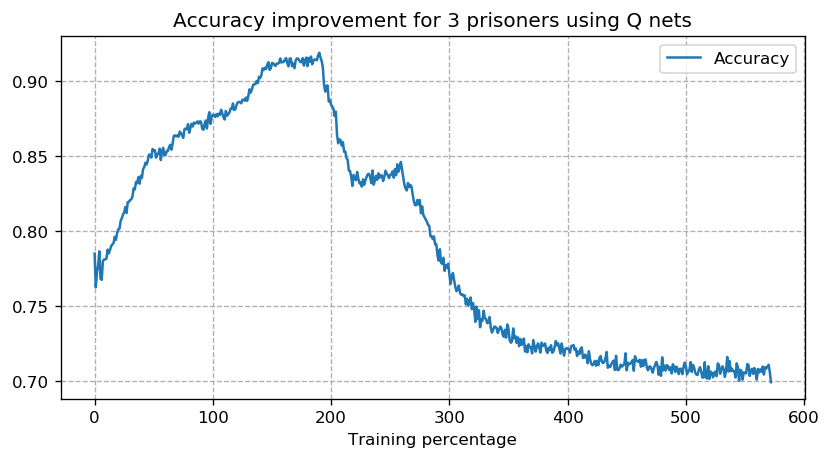

In [132]:
batch_accuracy = rList
plt.figure(figsize=(8, 4), dpi= 120)
plt.axes()
plt.title("Accuracy improvement for {0:d} prisoners using Q nets".format(number_of_agents))
plt.plot(batch_accuracy, label = "Accuracy")
plt.yscale("linear")
plt.xlabel("Training percentage")
plt.legend()
plt.grid(linestyle='--')


print("For training", number_of_agents, "agents (using Q nets), for", num_episodes, "episodes,")
print("the accuracy started at:", batch_accuracy[0], "and reached:", batch_accuracy[-1])